In [1]:
import numpy as np
from src.Simulator.SSA import SSASimulator
from src.Plotter.SystemPlotter import SysPlotter
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from src.Estimation.rnn import MultiRNNTrainer, Generator, split_dataset

2023-09-23 17:36:00.957601: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-23 17:36:00.959900: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-23 17:36:01.005874: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-23 17:36:01.006467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 17:36:01.497408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

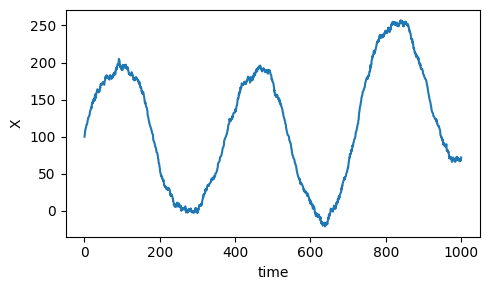

In [22]:
from src.Models.paper_examples import BirthDeathPaper
model_BD = BirthDeathPaper()
simulator_BD = SSASimulator(model_BD)

parameters_BD = model_BD.getDefaultParameter()
y, t = simulator_BD.run_ssa(np.array([100]), 1000, parameters_BD)

plotter = SysPlotter()
fig = plotter.plotSystem(y, t, model_BD)

Text(0, 0.5, 'X')

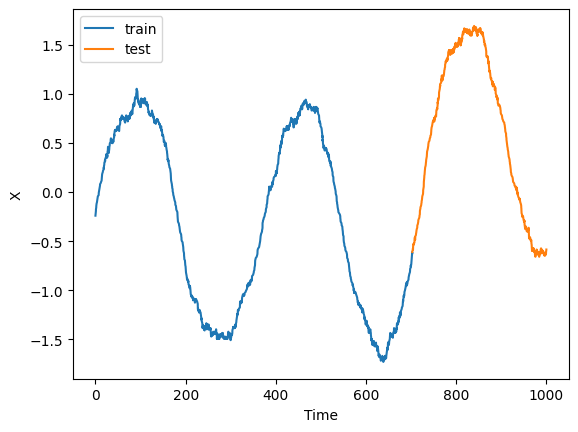

In [23]:
scaler = StandardScaler()
y = scaler.fit_transform(y)

data = pd.DataFrame(data={'t': t, "y": y.reshape(-1)})
data = data.rename(columns={'t': "time"})
data = split_dataset(data)

plt.plot(data["dataframe_0"]["train_data"].iloc[:,-1], label="train")
plt.plot(data["dataframe_0"]["test_data"].iloc[:,-1], label="test")
plt.legend()
plt.xlabel("Time")
plt.ylabel("X")

In [10]:
generator = Generator(input_width=3, label_width=1, train_df=data["dataframe_0"]["train_data"], test_df=data["dataframe_0"]["test_data"])
model = MultiRNNTrainer([generator.train_generator()])
model.compile_and_fit(epochs=10)

[<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>]
Epoch 1/10


2023-09-23 17:38:23.309735: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-09-23 17:38:23.309782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: markphillip
2023-09-23 17:38:23.309786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: markphillip
2023-09-23 17:38:23.309913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.54.3
2023-09-23 17:38:23.309935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  535.54.03  Release Build  (dvs-builder@U16-I2-C03-15-1)  Tue Jun  6 22:31:30 UTC 2023
GCC version:  gcc version 11.4.0 (Ubuntu 11.4.0-1ubuntu1~22.04) 
"


56/56 [==============================] - 1s 2ms/step - loss: 0.4918
Epoch 2/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0943
Epoch 3/10
56/56 [==============================] - 0s 3ms/step - loss: 0.0785
Epoch 4/10
56/56 [==============================] - 0s 3ms/step - loss: 0.0695
Epoch 5/10
56/56 [==============================] - 0s 3ms/step - loss: 0.0687
Epoch 6/10
56/56 [==============================] - 0s 3ms/step - loss: 0.0675
Epoch 7/10
56/56 [==============================] - 0s 3ms/step - loss: 0.0663
Epoch 8/10
56/56 [==============================] - 0s 3ms/step - loss: 0.0637
Epoch 9/10
56/56 [==============================] - 0s 3ms/step - loss: 0.0612
Epoch 10/10
56/56 [==============================] - 0s 3ms/step - loss: 0.0597


In [24]:
predictions = model.run_inference([generator.test_generator()])

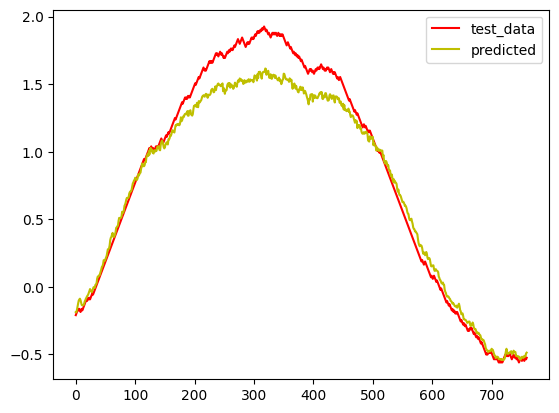

In [26]:
t = predictions['sequential']['targ']
p = predictions['sequential']['pred']

plt.plot(t, color='r', label="test_data")
plt.plot(p,color='y', label="predicted")
plt.legend()
plt.show()

In [35]:
from src.Models.paper_examples import ThreeSpeciesModel
model_LV = ThreeSpeciesModel()
simulator_LV = SSASimulator(model_LV)

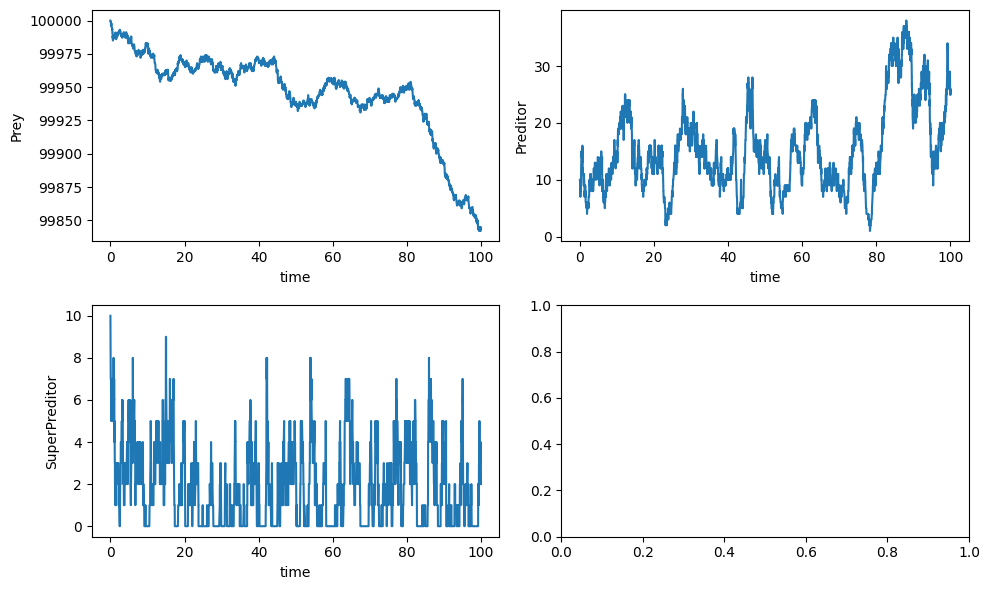

In [36]:
parameters_LV = model_LV.getDefaultParameter()

y, t = simulator_LV.run_ssa(np.array([10**5,10,10]), 100, parameters_LV)

plotter = SysPlotter()
fig = plotter.plotSystem(y, t, model_LV)

In [37]:
y = scaler.fit_transform(y)

data = pd.DataFrame({"t":t, "y_0": y[:,0], "y_1": y[:,1], "y_2": y[:,2]})
data = data.rename(columns={"t":"time"})

data = split_dataset(data)

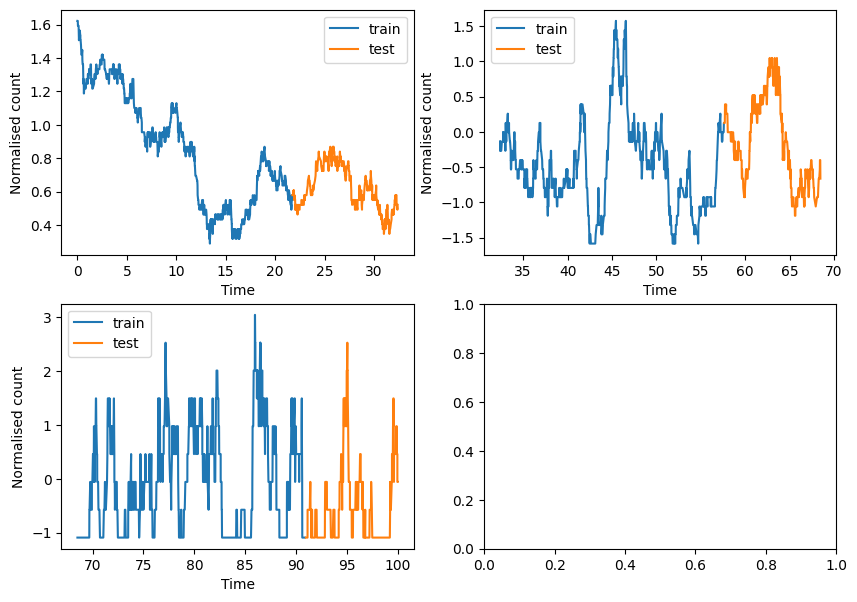

In [38]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
axes = axes.ravel()

for (data_key, ax) in zip(data, axes):
    ax.plot(data[data_key]["train_data"].iloc[:,-1], label="train")
    ax.plot(data[data_key]["test_data"].iloc[:,-1], label="test")
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Normalised count")
    ax.legend()
plt.show()

In [39]:
generator_1 = Generator(input_width=6, label_width=1, train_df=data["dataframe_0"]["train_data"],test_df=data["dataframe_0"]["test_data"])
generator_2 = Generator(input_width=6, label_width=1, train_df=data["dataframe_1"]["train_data"],test_df=data["dataframe_1"]["test_data"])
generator_3 = Generator(input_width=6, label_width=1, train_df=data["dataframe_2"]["train_data"],test_df=data["dataframe_2"]["test_data"])


In [40]:
model  = MultiRNNTrainer([generator_1.train_generator(),
                          generator_2.train_generator(),
                          generator_3.train_generator()])
model.compile_and_fit(epochs=10)

[<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>]
Epoch 1/10
32/32 [==============================] - 1s 5ms/step - loss: 0.6229
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.2264
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1425
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1069
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0942
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0699
Epoch 7/10
32/32 [==============================] - 0s

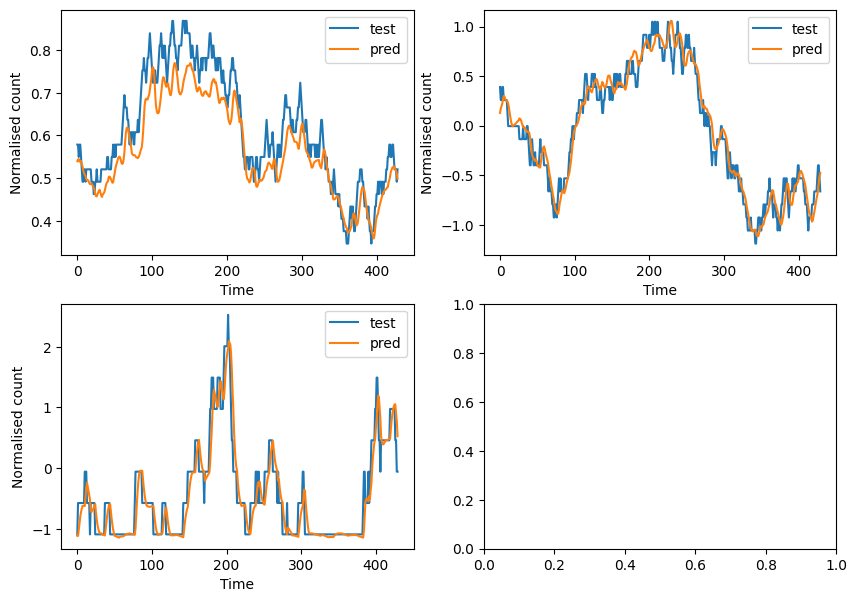

In [41]:
predictions = model.run_inference([generator_1.test_generator(), generator_2.test_generator(), generator_3.test_generator()])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
axes = axes.ravel()

for (prediction, ax) in zip(predictions, axes):
    ax.plot(predictions[prediction]['targ'], label="test")
    ax.plot(predictions[prediction]['pred'], label="pred")
    ax.set_xlabel("Time")
    ax.set_ylabel("Normalised count")
    ax.legend()
plt.show()

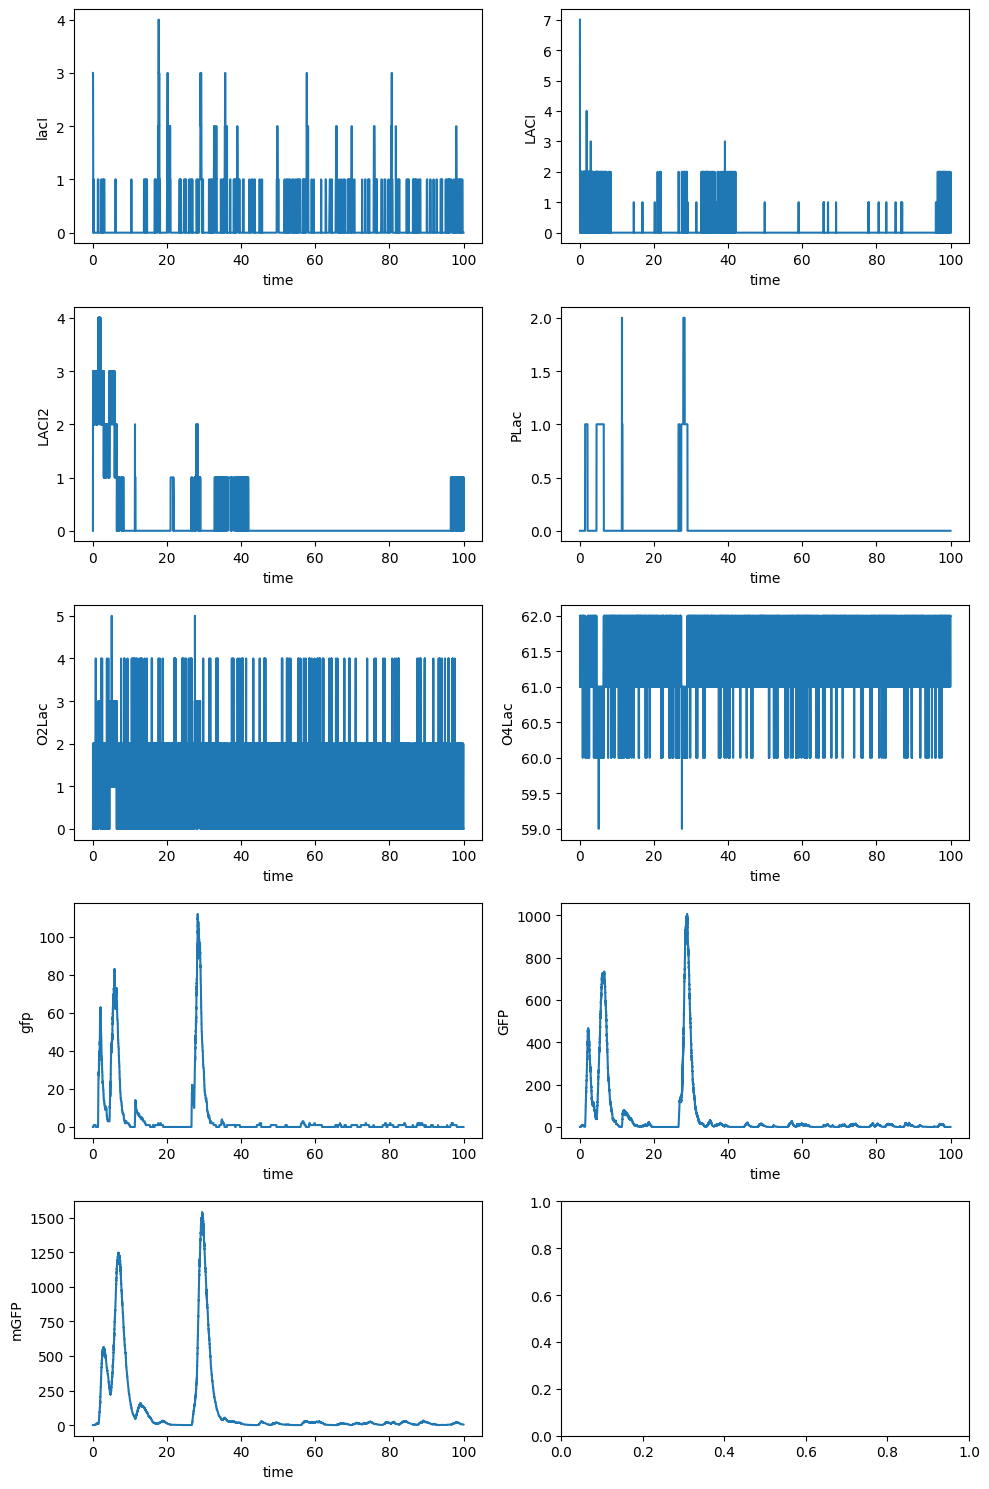

In [43]:
from src.Models.example_networks import LacGfp
model_lg = LacGfp()
simulator_lg = SSASimulator(model_lg)

parameters_lg = model_lg.getDefaultParameter()
x0 = model_lg.getDefaultInitialState()
y, t = simulator_lg.run_ssa(x0, 100, parameters_lg)

plotter = SysPlotter()
fig = plotter.plotSystem(y, t, model_lg)

In [48]:
y = scaler.fit_transform(y)

data = pd.DataFrame({"t":t, "y_0": y[:,0], 
                     "y_1": y[:,1], "y_2": y[:,2], 
                     "y_3": y[:,3], "y_4": y[:,4],
                     "y_5": y[:,5], "y_6": y[:,6],
                     "y_7": y[:,7], "y_8": y[:,8]})

data = data.rename(columns={"t":"time"})

data = split_dataset(data)

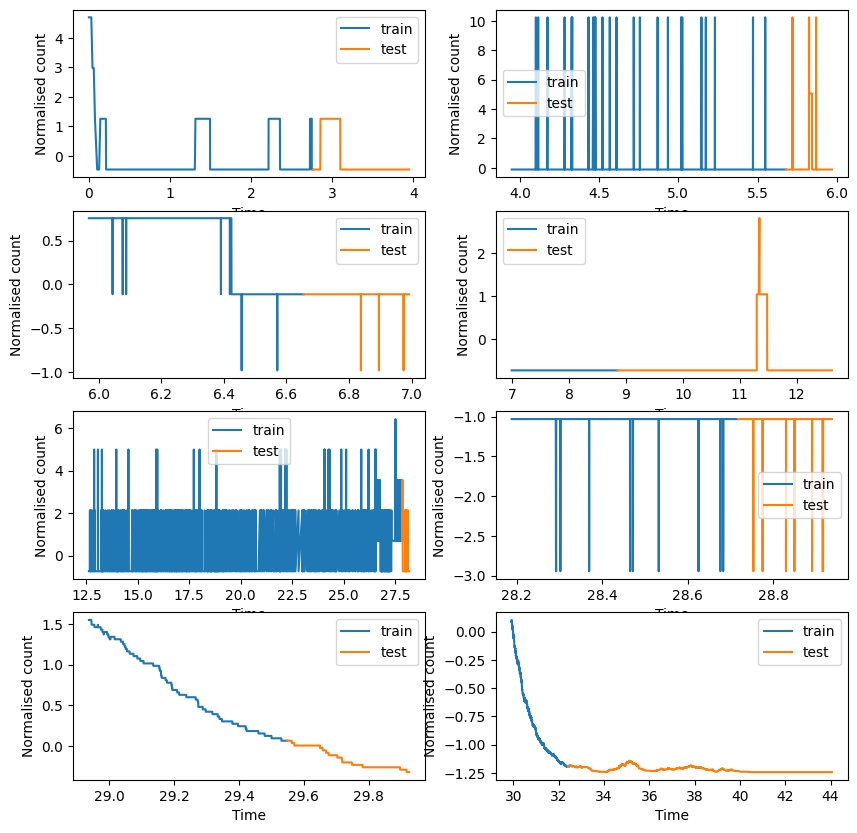

In [54]:
_, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,10))
axes = axes.ravel()

for (data_key, ax) in zip(data, axes):
    ax.plot(data[data_key]["train_data"].iloc[:,-1], label="train")
    ax.plot(data[data_key]["test_data"].iloc[:,-1], label="test")
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Normalised count")
    ax.legend()
plt.show()

In [56]:
generator_0 = Generator(input_width=6, label_width=1, train_df=data["dataframe_0"]["train_data"],test_df=data["dataframe_0"]["test_data"])
generator_1 = Generator(input_width=6, label_width=1, train_df=data["dataframe_1"]["train_data"],test_df=data["dataframe_1"]["test_data"])
generator_2 = Generator(input_width=6, label_width=1, train_df=data["dataframe_2"]["train_data"],test_df=data["dataframe_2"]["test_data"])
generator_3 = Generator(input_width=6, label_width=1, train_df=data["dataframe_3"]["train_data"],test_df=data["dataframe_3"]["test_data"])
generator_4 = Generator(input_width=6, label_width=1, train_df=data["dataframe_4"]["train_data"],test_df=data["dataframe_4"]["test_data"])
generator_5 = Generator(input_width=6, label_width=1, train_df=data["dataframe_5"]["train_data"],test_df=data["dataframe_5"]["test_data"])
generator_6 = Generator(input_width=6, label_width=1, train_df=data["dataframe_6"]["train_data"],test_df=data["dataframe_6"]["test_data"])
generator_7 = Generator(input_width=6, label_width=1, train_df=data["dataframe_7"]["train_data"],test_df=data["dataframe_7"]["test_data"])
generator_8 = Generator(input_width=6, label_width=1, train_df=data["dataframe_8"]["train_data"],test_df=data["dataframe_8"]["test_data"])

In [57]:
model  = MultiRNNTrainer([generator_0.train_generator(),
                          generator_1.train_generator(),
                          generator_2.train_generator(),
                          generator_3.train_generator(),
                          generator_4.train_generator(),
                          generator_5.train_generator(),
                          generator_6.train_generator(),
                          generator_7.train_generator(),
                          generator_8.train_generator(),])
model.compile_and_fit(epochs=10)

[<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, None, 

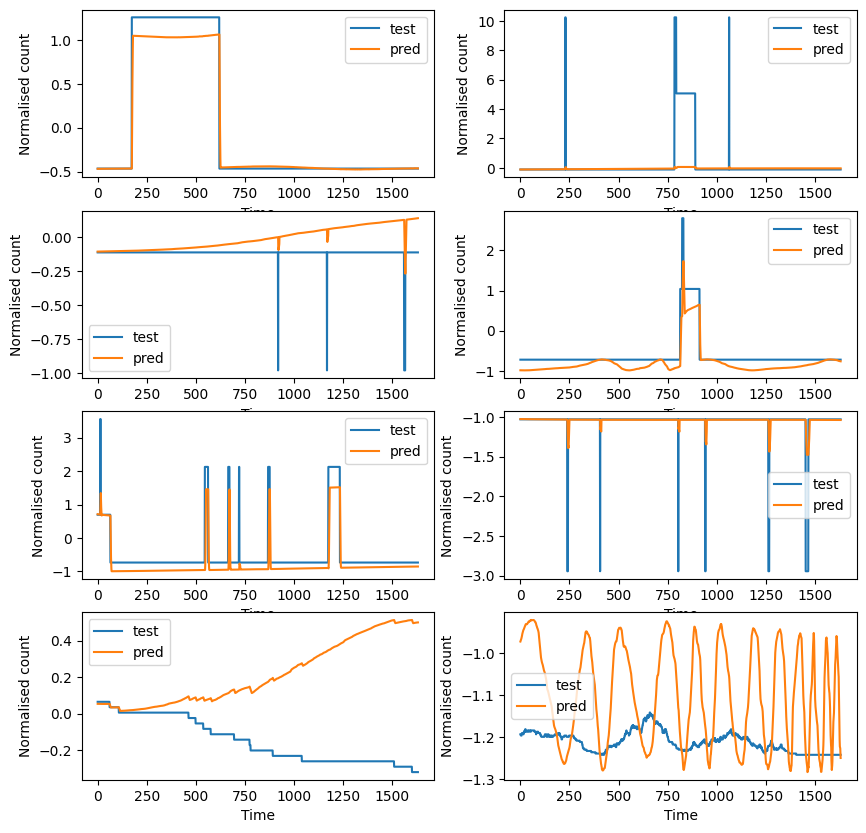

In [60]:
predictions = model.run_inference([generator_0.test_generator(),
                                   generator_1.test_generator(),
                                   generator_2.test_generator(), 
                                   generator_3.test_generator(),
                                   generator_4.test_generator(),
                                   generator_5.test_generator(),
                                   generator_6.test_generator(),
                                   generator_7.test_generator(),
                                   generator_8.test_generator(),])

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,10))
axes = axes.ravel()

for (prediction, ax) in zip(predictions, axes):
    ax.plot(predictions[prediction]['targ'], label="test")
    ax.plot(predictions[prediction]['pred'], label="pred")
    ax.set_xlabel("Time")
    ax.set_ylabel("Normalised count")
    ax.legend()
plt.show()